In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<pre><font size=6>Spoken Digit Recognition</font></pre>

<pre>
In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number
It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

</pre>

In [ ]:
!pip3 install tensorflow==2.3

In [2]:
import numpy as np
import pandas as pd
import librosa
import os
##if you need any imports you can do that here. 

We shared recordings.zip, please unzip those. 

In [3]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
all_files=os.listdir('/content/drive/MyDrive/Spoken_digit_assignment/recordings/')

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [6]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0
dir='/content/drive/MyDrive/Spoken_digit_assignment/recordings/'
label=[]
path=[]
for f in all_files:
  path.append(dir+f)
  
  x=f.split('_')
  label.append(int(x[0]))

df_audio=pd.DataFrame({'path':path,'label':label})



In [7]:
df_audio['label'].max()

9

In [8]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [10]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [11]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
from sklearn.model_selection import train_test_split
X=df_audio['path']
Y=df_audio['label']
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.3,random_state=45,stratify=Y)

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [13]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [14]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
from tqdm import tqdm
train_samples=[]
train_duration=[]
test_samples=[]
test_duration=[]

for f in tqdm(X_train):
  train_samples.append(load_wav(f)[0])
  train_duration.append(load_wav(f)[1])

for f in tqdm(X_test):    
  test_samples.append(load_wav(f)[0])
  test_duration.append(load_wav(f)[1])

X_train_processed = pd.DataFrame({'raw_data':train_samples,
                               'duration':train_duration})

X_test_processed = pd.DataFrame({'raw_data':test_samples,
                               'duration':test_duration})

100%|██████████| 600/600 [00:13<00:00, 43.28it/s]


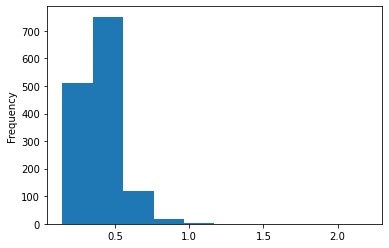

In [15]:
#plot the histogram of the duration for trian
X_train_processed['duration'].plot.hist()

In [16]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0,110,10):
  print(str(i)+'th percentile is ',np.percentile(X_train_processed['duration'],q=i))

0th percentile is  0.1435374149659864
10th percentile is  0.26312925170068024
20th percentile is  0.30006349206349203
30th percentile is  0.33207256235827665
40th percentile is  0.3590839002267574
50th percentile is  0.3902947845804989
60th percentile is  0.41811337868480725
70th percentile is  0.44597732426303854
80th percentile is  0.4816326530612245
90th percentile is  0.5533106575963719
100th percentile is  2.195918367346939


In [17]:
##print 90 to 100 percentile values with step size of 1. 
for i in range(90,101):
  print(str(i)+'th percentile is ',np.percentile(X_train_processed['duration'],q=i))

90th percentile is  0.5533106575963719
91th percentile is  0.5669832199546486
92th percentile is  0.5794503401360545
93th percentile is  0.5985732426303856
94th percentile is  0.611208163265306
95th percentile is  0.6227800453514739
96th percentile is  0.6366947845804989
97th percentile is  0.6587115646258503
98th percentile is  0.6838566893424036
99th percentile is  0.784215873015873
100th percentile is  2.195918367346939


<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [19]:
X_train_processed.shape

(1400, 2)

In [20]:
max_length  = 17640

In [21]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask
## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.
from tensorflow.keras.preprocessing.sequence import pad_sequences

def create_mask(x):
   if len(x)<max_length:
     return [*[1]*len(x),*[0]*(max_length-len(x))]
   else:
     return [*[1]*max_length]
                                                                                                                                                                  
                                                                              

X_train_pad_seq= np.array(pad_sequences(X_train_processed['raw_data'], dtype='float32', padding='post',maxlen=max_length))
X_test_pad_seq= np.array(pad_sequences(X_test_processed['raw_data'], dtype="float32", padding='post', maxlen=max_length))

X_train_mask= np.array([create_mask(i) for i in X_train_processed['raw_data']],dtype=bool)
X_test_mask= np.array([create_mask(i) for i in X_test_processed['raw_data'] ],dtype=bool)

In [22]:
X_test_mask.shape

(600, 17640)

### 1. Giving Raw data directly. 

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). 
3. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
4. make sure that it won't overfit. 
5. You are free to include any regularization
</pre>

In [24]:
from tensorflow.keras.layers import Input, LSTM, Dense,Embedding
from tensorflow.keras.models import Model
import tensorflow as tf

In [90]:
## as discussed above, please write the LSTM
In=Input(shape=(max_length,1))
In2=Input(shape=(max_length),dtype=bool)
LS=LSTM(50)(In,mask=In2)
D1=Dense(32,activation='relu')(LS)
OUT=Dense(10,activation='softmax')(D1)
model=Model(inputs=([In,In2]),outputs=OUT)

In [91]:
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 50)           10400       input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 32)           1632        lstm_8[0][0]         

In [93]:
from datetime import datetime
from sklearn.metrics import f1_score

In [113]:
class Metrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.val_f1 = []

    def on_epoch_end(self, epoch, logs={}):
      val_predict = (np.asarray(self.model.predict([X_test_pad_seq,X_test_mask]))).round()
      
      digit_predict=[]
      
      for i in val_predict:
        digit_predict.append(np.argmax(i))
      val_targ = y_test
      
      f1 = f1_score(val_targ, digit_predict,average='micro')
      
      self.val_f1.append(f1)
      
      print(" Micro_f1_score:",f1)
        
metrics = Metrics()
logdir='/content/drive/MyDrive/Spoken_digit_assignment/logs/'+datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,)
 
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_acc',mode='max',patience=2)

optim=tf.keras.optimizers.Adam()

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optim,loss=loss,metrics=['acc'])

In [114]:
X_train_full=[X_train_pad_seq,X_train_mask]

X_test_full=[X_test_pad_seq,X_test_mask]

In [116]:
model.fit(X_train_full,y_train,validation_data=[X_test_full,y_test],epochs=20,batch_size=100,
          callbacks=[tensorboard,early_stopping,metrics])

Epoch 1/20
14/14 [==============================] - 18s 1s/step - loss: 2.3026 - acc: 0.1007 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/20
14/14 [==============================] - 14s 997ms/step - loss: 2.3026 - acc: 0.1007 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/20
14/14 [==============================] - 14s 994ms/step - loss: 2.3026 - acc: 0.1007 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00


### 2. Converting into spectrogram and giving spectrogram data as input  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [34]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [35]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram=[]
for i in X_train_pad_seq:
  X_train_spectrogram.append(convert_to_spectrogram(i))
X_train_spectrogram=np.array(X_train_spectrogram,dtype='float')

X_test_spectrogram=[]
for i in X_test_pad_seq:
  X_test_spectrogram.append(convert_to_spectrogram(i))
X_test_spectrogram=np.array(X_test_spectrogram,dtype='float')

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (#., time_steps, features) average the output of every time step i.e, you should get (#.,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
5. make sure that it won't overfit. 
6. You are free to include any regularization
</pre>

In [37]:
logdir='/content/drive/MyDrive/Spoken_digit_assignment/model2_logs/'+datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)



In [38]:
X_train_spectrogram.shape

(1400, 64, 35)

In [119]:

In=Input(shape=(64,35,))

LS=LSTM(units=100,return_sequences=True)(In)

output=tf.keras.layers.Reshape(target_shape=(64,100,1))(LS)

output=tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(output)

output=tf.keras.layers.Reshape(target_shape=(64,))(output)

output=Dense(128,activation='relu')(output)

output=Dense(64,activation='relu')(output)

predict=Dense(10,activation='softmax')(output)

model2=Model(inputs=In,outputs=predict)

In [120]:
model2.summary()

Model: "functional_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 64, 35)]          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64, 100)           54400     
_________________________________________________________________
reshape_17 (Reshape)         (None, 64, 100, 1)        0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 64, 1)             0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_29 (Dense)             (None, 64)              

In [121]:
X_train_spectrogram.shape

(1400, 64, 35)

In [122]:
optim=tf.keras.optimizers.Adam()
loss=tf.keras.losses.SparseCategoricalCrossentropy()
model2.compile(optimizer=optim,loss=loss,metrics=['acc'])
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=3,mode='max')

In [123]:
y_train=np.array(y_train,dtype='float')
y_test=np.array(y_test,dtype='float')

In [124]:
X_test_spectrogram.shape

(600, 64, 35)

In [125]:
from sklearn.metrics import f1_score
class Metrics2(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.val_f1s = []

    def on_epoch_end(self, epoch, logs={}):
      val_predict = (np.asarray(self.model.predict(X_test_spectrogram))).round()
      
      digit_predict=[]
      
      for i in val_predict:
        digit_predict.append(np.argmax(i))
      
      val_targ = y_test
      f1 = f1_score(val_targ, digit_predict,average='micro')
      self.val_f1s.append(f1)
      print("Micro f1 score:",f1)
        
metrics2 = Metrics2()

model2.fit(x=X_train_spectrogram,
           y=y_train,
           epochs=200,
           batch_size=100,
           callbacks=[tensorboard,metrics2],
           validation_data=[X_test_spectrogram,y_test])

Epoch 1/200
14/14 [==============================] - 1s 74ms/step - loss: 2.2898 - acc: 0.1571 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 2.2130 - acc: 0.2143 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 2.0512 - acc: 0.3179 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/200
14/14 [==============================] - 0s 14ms/step - loss: 1.8038 - acc: 0.3900 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/200
14/14 [==============================] - 0s 14ms/step - loss: 1.5534 - acc: 0.4271 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 6/200
14/14 [==============================] - 0s 14ms/step - loss: 1.3745 - acc: 0.5107 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 7/200
14/14 [==============================] - 0s 14ms/step - loss: 1.2332 - acc: 0.5836 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 8/200
14/14 [=

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Spoken_digit_assignment/model2_logs/20210728-105556/

### 3. data augmentation  
<pre>
Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [136]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [137]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [138]:
len(aug_temp)

9

As discussed above, for one data point, we will get 9 augmented data points.  

Split data into train and test (80-20 split)

We have 2000 data points(1600 train points, 400 test points) 

Do augmentation only on train data, after augmentation we will get 14400 train points. 

do the above steps i.e training with raw data and spectrogram data with augmentation.

In [ ]:
from tqdm import tqdm 

dir='/content/drive/MyDrive/Spoken_digit_assignment/recordings/'

X=[]
Y=[]

for i in tqdm(all_files):
  a=generate_augmented_data(dir+i)
  for j in a:
    X.append(j)
  b=load_wav(dir+i)[0]
  X.append(b)
  for j in range(10):
    Y.append(int(i.split('_')[0]))

In [156]:
X=np.array(X)
Y=np.array(Y)

In [157]:
X_train_new,X_test_new,Y_train_new,Y_test_new=train_test_split(X,Y,test_size=0.2,stratify=Y)

In [169]:
X_train_pad_seq_new= np.array(pad_sequences(X_train_new, dtype='float32', padding='post',maxlen=max_length))
X_test_pad_seq_new= np.array(pad_sequences(X_test_new, dtype="float32", padding='post', maxlen=max_length))

X_train_mask_new= np.array([create_mask(i) for i in X_train_new],dtype=bool)
X_test_mask_new= np.array([create_mask(i) for i in X_test_new],dtype=bool)

In [170]:
In=Input(shape=(max_length,1))
In2=Input(shape=(max_length),dtype=bool)
LS=LSTM(50)(In,mask=In2)
D1=Dense(32,activation='relu')(LS)
OUT=Dense(10,activation='softmax')(D1)
model3=Model(inputs=([In,In2]),outputs=OUT)

In [179]:
class Metrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.val_f1 = []

    def on_epoch_end(self, epoch, logs={}):
      val_predict = (np.asarray(self.model.predict([X_test_pad_seq_new,X_test_mask_new]))).round()
      
      digit_predict=[]
      
      for i in val_predict:
        digit_predict.append(np.argmax(i))
      val_targ = Y_test_new
      
      f1 = f1_score(val_targ, digit_predict,average='micro')
      
      self.val_f1.append(f1)
      
      print(" Micro_f1_score:",f1)
        
metrics = Metrics()
logdir='/content/drive/MyDrive/Spoken_digit_assignment/model3_logs/'+datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,)
 
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_acc',mode='max',patience=2)

optim=tf.keras.optimizers.Adam()

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model3.compile(optimizer=optim,loss=loss,metrics=['acc'])

In [180]:
X_train_full=[X_train_pad_seq_new,X_train_mask_new]

X_test_full=[X_test_pad_seq_new,X_test_mask_new]

In [181]:
X_test

1731    /content/drive/MyDrive/Spoken_digit_assignment...
1693    /content/drive/MyDrive/Spoken_digit_assignment...
610     /content/drive/MyDrive/Spoken_digit_assignment...
1966    /content/drive/MyDrive/Spoken_digit_assignment...
518     /content/drive/MyDrive/Spoken_digit_assignment...
                              ...                        
650     /content/drive/MyDrive/Spoken_digit_assignment...
873     /content/drive/MyDrive/Spoken_digit_assignment...
787     /content/drive/MyDrive/Spoken_digit_assignment...
918     /content/drive/MyDrive/Spoken_digit_assignment...
1863    /content/drive/MyDrive/Spoken_digit_assignment...
Name: path, Length: 600, dtype: object

In [183]:
model3.fit(X_train_full,Y_train_new,validation_data=[X_test_full,Y_test_new],epochs=1,batch_size=100,
          callbacks=[tensorboard,early_stopping,metrics])

160/160 [==============================] - 151s 945ms/step - loss: 2.3027 - acc: 0.0973 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00


In [184]:
X_train_spectrogram_new=[]
for i in X_train_pad_seq_new:
  X_train_spectrogram_new.append(convert_to_spectrogram(i))
X_train_spectrogram_new=np.array(X_train_spectrogram_new)



In [189]:
X_test_spectrogram_new=[]
for i in X_test_pad_seq_new:
  X_test_spectrogram_new.append(convert_to_spectrogram(i))
X_test_spectrogram_new=np.array(X_test_spectrogram_new)


In [193]:
logdir='/content/drive/MyDrive/Spoken_digit_assignment/model4_logs/'+datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,)

class Metrics2(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.val_f1s = []

    def on_epoch_end(self, epoch, logs={}):
      val_predict = (np.asarray(self.model.predict(X_test_spectrogram_new))).round()
      
      digit_predict=[]
      
      for i in val_predict:
        digit_predict.append(np.argmax(i))
      
      val_targ = Y_test_new
      f1 = f1_score(val_targ, digit_predict,average='micro')
      self.val_f1s.append(f1)
      print("Micro f1 score:",f1)
        
metrics2 = Metrics2()




In [194]:
In=Input(shape=(64,35,))

LS=LSTM(units=100,return_sequences=True)(In)

output=tf.keras.layers.Reshape(target_shape=(64,100,1))(LS)

output=tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(output)

output=tf.keras.layers.Reshape(target_shape=(64,))(output)

output=Dense(128,activation='relu')(output)

output=Dense(64,activation='relu')(output)

predict=Dense(10,activation='softmax')(output)

model4=Model(inputs=In,outputs=predict)

In [195]:
optim=tf.keras.optimizers.Adam()
loss=tf.keras.losses.SparseCategoricalCrossentropy()
model4.compile(optimizer=optim,loss=loss,metrics=['acc'])
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=3,mode='max')

In [198]:
model4.fit(x=X_train_spectrogram_new,
           y=Y_train_new,
           epochs=100,
           batch_size=100,
           callbacks=[tensorboard,metrics2],
           validation_data=[X_test_spectrogram_new,Y_test_new])

Epoch 1/100
160/160 [==============================] - 2s 13ms/step - loss: 1.4723 - acc: 0.4869 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/100
160/160 [==============================] - 1s 9ms/step - loss: 0.7097 - acc: 0.7551 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/100
160/160 [==============================] - 1s 9ms/step - loss: 0.5293 - acc: 0.8163 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/100
160/160 [==============================] - 1s 9ms/step - loss: 0.4434 - acc: 0.8474 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/100
160/160 [==============================] - 1s 9ms/step - loss: 0.3856 - acc: 0.8690 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 6/100
160/160 [==============================] - 1s 9ms/step - loss: 0.3471 - acc: 0.8841 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 7/100
160/160 [==============================] - 1s 9ms/step - loss: 0.3179 - acc: 0.8946 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 8/100


In [200]:
models=['model 1 (pad_seq+mask)',
         'model 2 (spectogram)',
         'model 3 (pad_seq+aug+mask)',
         'model 3 (aug spectogram)']

scores=[ 0.10000000000000002,
         0.9383333333333334,
         0.10000000000000002,
         0.96825]

df=pd.DataFrame({'models':models,'f1_scores':scores})
df

,models,f1_scores
0,model 1 (pad_seq+mask),0.100000
1,model 2 (spectogram),0.938333
2,model 3 (pad_seq+aug+mask),0.100000
3,model 3 (aug spectogram),0.968250
